In [1]:
import os
import copy
import random
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [2]:
def createpres(p, resamplelen):

  #p = signal.resample(p, (len(p))//resamplelen).tolist()
  p = p[0].values.tolist()
  return p


from google.colab import drive
drive.mount('/content/drive')

names = pd.read_csv('/content/drive/MyDrive/channels.tbl.20250225', delimiter=' ')
names = names.T.values.tolist()

pathtopressure = r'/content/drive/MyDrive/resampled/2025_18days'

presnames = names[0]

#sequence_length = 287
sequence_length = 432
resamplelen = 1
num_stations = len(names[0])

pressure_n = []
station_data = {}
pressure=[]

for i in range(num_stations):
  pressure_n = createpres(pd.read_csv(pathtopressure + presnames[i] + '.dat', delimiter='\t', header=None)[:sequence_length], resamplelen)
  pressure.append(pressure_n)
  station_data[f'station_{i}'] = pd.Series(pressure_n, index=pd.date_range("2025-02-23", periods=sequence_length, freq="h"))

fullstationdata = copy.deepcopy(station_data)
print(0)

Mounted at /content/drive
0


In [9]:

import os
import random
from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import layers, models, callbacks

# ---------------- device / strategy setup ----------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth for GPUs.")
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU found. Code will run on CPU.")

# Use MirroredStrategy if multiple GPUs present (otherwise strategy will just be default single-worker)
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print("Using MirroredStrategy with", strategy.num_replicas_in_sync, "replicas.")
else:
    strategy = tf.distribute.get_strategy()  # default strategy (no distribution)
    print("Using default strategy.")


start = [0, 84, 168, 252]
end   = [84, 168, 252, 336]
# worst — malfunctioning stations' id
worst = [15, 16, 37, 38, 51, 52, 72, 73, 74, 86, 87, 125, 126, 152, 153,
         179, 180, 207, 208, 215, 216, 90, 91, 23, 24, 80, 81, 203, 204]
to_remove = [80, 81, 336, 337]  # deleting first 2 periods for the station which failed during observation
test_size = 0.2
random_state = 42
metric_to_optimize = 'f1'
n_thresholds = 200
latent_dim = 16
# ----------------------------------------------


def select_grouped_stations(names, bad, K, N, seed=None):
    if seed is not None:
        random.seed(seed)

    num_stations = len(names[0])
    indices = list(range(num_stations))

    # names[3][i] - name of the i-th station (as in original)
    groups = defaultdict(list)
    for i in indices:
        key = names[3][i]
        groups[key].append(i)

    # Grouping into bad/neutral depending on whether any index in group intersects bad
    group_categories = {'bad': [], 'neutral': []}
    bad_set = set(bad)

    for group in groups.values():
        group_set = set(group)
        if group_set & bad_set:
            group_categories['bad'].append(group)
        else:
            group_categories['neutral'].append(group)

    def select_groups_with_limit(group_list, target_count, current_total, max_total):
        random.shuffle(group_list)
        selected = []
        selected_count = 0
        for group in group_list:
            group_len = len(group)
            if selected_count >= target_count:
                break
            if current_total + group_len > max_total:
                continue  # Skip the group if it does not fit in
            selected.append(group)
            selected_count += group_len
            current_total += group_len
        return selected, selected_count, current_total

    # Group selection: first pick bad groups, then neutral to fill up to N
    selected_bad, count_bad, total_count = select_groups_with_limit(group_categories['bad'], K, 0, N)

    selected_neutral, count_neutral, total_count = select_groups_with_limit(
        group_categories['neutral'], N - (count_bad), total_count, N
    )

    selected_groups = selected_bad + selected_neutral
    final_selection = [i for group in selected_groups for i in group]

    return final_selection

X_list = []
sample_station_idx = []
sample_segment_idx = []
for seg_idx, (s_idx, e_idx) in enumerate(zip(start, end)):
    for st in range(num_stations):
        arr = fullstationdata[f'station_{st}'].iloc[s_idx:e_idx].values
        X_list.append(arr)
        sample_station_idx.append(st)
        sample_segment_idx.append(seg_idx)
X = np.array(X_list)
num_samples = X.shape[0]
assert num_samples == num_stations * len(start)

bad = worst.copy()
for k in range(1, len(start)):
    bad += [x + k * num_stations for x in worst]
for r in to_remove:
    try:
        bad.remove(r)
    except ValueError:
        pass

y = np.zeros(num_samples, dtype=int)
for idx in bad:
    if 0 <= idx < num_samples:
        y[idx] = 1

print("Total y distribution:", np.bincount(y))


K = len(worst) // len(start)
N = len(names[0]) // len(start)
selected = select_grouped_stations(names, worst, K, N, seed=random_state)
print(f"Number of selected stations (grouped): {len(selected)}")
print(f"Number of bad stations among selected: {len(set(selected) & set(worst))}")


train_stations = [s for s in range(num_stations) if s not in selected]
val_stations = selected.copy()
print("Train stations:", len(train_stations), "Val stations:", len(val_stations))


train_idx = []
val_idx = []
n_segments = len(start)
for seg in range(n_segments):
    for st in train_stations:
        train_idx.append(seg * num_stations + st)
    for st in val_stations:
        val_idx.append(seg * num_stations + st)

train_idx = np.array(train_idx, dtype=int)
val_idx = np.array(val_idx, dtype=int)

X_train_raw = X[train_idx]
X_val_raw = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]

print("X_train_raw shape:", X_train_raw.shape, "X_val_raw shape:", X_val_raw.shape)
print("y_train dist:", np.bincount(y_train), "y_val dist:", np.bincount(y_val))

# ---------- reshape/scale/train AE ----------
timesteps = X_train_raw.shape[1]
features = 1
X_train = X_train_raw.reshape((X_train_raw.shape[0], timesteps, features))
X_val = X_val_raw.reshape((X_val_raw.shape[0], timesteps, features))

scaler = StandardScaler()
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_val_scaled_flat = scaler.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(X_val.shape)


# ---------------- ensure float32 ----------------
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

# If you train AE only on normal samples:
if 0 in y_train:
    normal_mask = (y_train == 0)
    X_train_ae = X_train_scaled[normal_mask]
    if X_train_ae.shape[0] < 5:
        print("Too few normal samples in train, training on full train.")
        X_train_ae = X_train_scaled
else:
    X_train_ae = X_train_scaled

print("AE training set shape (float32):", X_train_ae.shape)

# ----------------- tf.data datasets for GPU efficiency -----------------
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Training dataset: (X_train_ae, X_train_ae) for autoencoder
train_ds = tf.data.Dataset.from_tensor_slices((X_train_ae, X_train_ae))
train_ds = train_ds.shuffle(buffer_size=min(1000, X_train_ae.shape[0]), seed=random_state).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Validation dataset used by Keras during fit (X_val_scaled -> reconstruct X_val_scaled)
val_ds_for_fit = tf.data.Dataset.from_tensor_slices((X_val_scaled, X_val_scaled)).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Dataset for fast prediction
val_pred_ds = tf.data.Dataset.from_tensor_slices(X_val_scaled).batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_pred_ds = tf.data.Dataset.from_tensor_slices(X_train_scaled).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --------------- build model inside strategy scope ---------------
timesteps = X_train_scaled.shape[1]
features = X_train_scaled.shape[2]

with strategy.scope():
    input_shape = (timesteps, features)
    enc_inputs = layers.Input(shape=input_shape, dtype=tf.float32)
    x = layers.LSTM(256, return_sequences=True)(enc_inputs)
    x = layers.LSTM(128, return_sequences=False)(x)
    latent = layers.Dense(latent_dim, activation='relu')(x)
    x = layers.RepeatVector(timesteps)(latent)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    dec_outputs = layers.TimeDistributed(layers.Dense(features, dtype='float32'))(x)
    autoencoder = models.Model(enc_inputs, dec_outputs, name="lstm_autoencoder")
    optimizer = tf.keras.optimizers.Adam()
    autoencoder.compile(optimizer=optimizer, loss='mse', run_eagerly=False)

autoencoder.summary()

# --------------- callbacks ---------------
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("lstm_autoencoder_best.h5", save_best_only=True, monitor='val_loss', save_weights_only=False)

# --------------- fit (will run on GPU) ---------------
EPOCHS = 200
history = autoencoder.fit(train_ds,
                          epochs=EPOCHS,
                          validation_data=val_ds_for_fit,
                          callbacks=[es, checkpoint],
                          verbose=2)

# --------------- predictions (fast on GPU) ---------------

mse_per_sample = lambda y_true, y_pred: np.mean(np.mean((y_pred - y_true)**2, axis=1), axis=1)

# Predict on validation (returns numpy array)
X_val_pred = autoencoder.predict(val_pred_ds)
mse_val = np.mean(np.mean((X_val_pred - X_val_scaled)**2, axis=(1,2)), axis=0)  # this line is wrong — fix in next lines
mse_val = np.mean((X_val_pred - X_val_scaled)**2, axis=(1,2))

# For train MSE (for percentile fallback)
X_train_pred = autoencoder.predict(train_pred_ds)
mse_train = np.mean((X_train_pred - X_train_scaled)**2, axis=(1,2))

# --------------- threshold selection ---------------
best_threshold = None
best_score = -np.inf

if len(np.unique(y_val)) > 1 and y_val.sum() > 0:
    t_min, t_max = float(mse_val.min()), float(mse_val.max())
    thresholds = np.linspace(t_min, t_max, n_thresholds)
    for t in thresholds:
        y_pred = (mse_val > t).astype(int)
        if metric_to_optimize == 'f1':
            score = f1_score(y_val, y_pred, zero_division=0)
        elif metric_to_optimize == 'precision':
            score = precision_score(y_val, y_pred, zero_division=0)
        elif metric_to_optimize == 'recall':
            score = recall_score(y_val, y_pred, zero_division=0)
        elif metric_to_optimize == 'accuracy':
            score = accuracy_score(y_val, y_pred)
        elif metric_to_optimize == 'average_precision':
            try:
                score = average_precision_score(y_val, mse_val)
            except:
                score = 0
        elif metric_to_optimize == 'roc_auc':
            try:
                score = roc_auc_score(y_val, mse_val)
            except:
                score = 0
        else:
            score = f1_score(y_val, y_pred, zero_division=0)

        if score > best_score:
            best_score = score
            best_threshold = t

    print(f"Chosen threshold by {metric_to_optimize} on validation: {best_threshold:.6e} (score={best_score:.4f})")
else:
    best_threshold = np.percentile(mse_train, 95)
    print("Fallback threshold (95th percentile of train):", best_threshold)

# --------------- final evaluation ---------------
y_val_pred = (mse_val > best_threshold).astype(int)
print("Validation metrics:")
print("Precision:", precision_score(y_val, y_val_pred, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred, zero_division=0))
print("F1       :", f1_score(y_val, y_val_pred, zero_division=0))
print("Accuracy :", accuracy_score(y_val, y_val_pred))
try:
    print("ROC AUC  :", roc_auc_score(y_val, mse_val))
except Exception:
    print("ROC AUC  : could not compute (need two classes in y_val)")
try:
    print("AUPR     :", average_precision_score(y_val, mse_val))
except Exception:
    print("AUPR     : could not compute")
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))

# save final artifacts
autoencoder.save("lstm_autoencoder_model.h5")
np.save("reconstruction_threshold.npy", np.array([best_threshold]))
print("Saved model and threshold.")


GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Enabled memory growth for GPUs.
Using default strategy.
Total y distribution: [912 112]
Number of selected stations (grouped): 64
Number of bad stations among selected: 8
Train stations: 192 Val stations: 64
X_train_raw shape: (768, 84) X_val_raw shape: (256, 84)
y_train dist: [684  84] y_val dist: [228  28]
AE training set shape (float32): (684, 84, 1)


Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 84, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 84, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 84, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 84, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 84, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 84, 1)          │           257 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,113 (3.56 MB)

 Trainable params: 932,113 (3.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


11/11 - 11s - 991ms/step - loss: 0.3662 - val_loss: 0.0645
Epoch 2/200


11/11 - 0s - 43ms/step - loss: 0.0835 - val_loss: 0.0517
Epoch 3/200


11/11 - 0s - 42ms/step - loss: 0.0509 - val_loss: 0.0335
Epoch 4/200


11/11 - 0s - 41ms/step - loss: 0.0336 - val_loss: 0.0243
Epoch 5/200


11/11 - 0s - 43ms/step - loss: 0.0243 - val_loss: 0.0182
Epoch 6/200


11/11 - 0s - 40ms/step - loss: 0.0194 - val_loss: 0.0155
Epoch 7/200


11/11 - 0s - 41ms/step - loss: 0.0156 - val_loss: 0.0124
Epoch 8/200
11/11 - 0s - 38ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 9/200


11/11 - 0s - 41ms/step - loss: 0.0124 - val_loss: 0.0113
Epoch 10/200


11/11 - 0s - 42ms/step - loss: 0.0103 - val_loss: 0.0082
Epoch 11/200


11/11 - 0s - 40ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 12/200
11/11 - 0s - 35ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 13/200


11/11 - 0s - 41ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 14/200


11/11 - 0s - 41ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 15/200


11/11 - 0s - 41ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 16/200


11/11 - 0s - 40ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 17/200


11/11 - 0s - 43ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 18/200
11/11 - 0s - 35ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 19/200


11/11 - 0s - 41ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 20/200
11/11 - 0s - 35ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 21/200
11/11 - 0s - 40ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 22/200
11/11 - 0s - 43ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 23/200


11/11 - 1s - 46ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 24/200


11/11 - 1s - 48ms/step - loss: 0.0014 - val_loss: 9.8230e-04
Epoch 25/200


11/11 - 1s - 58ms/step - loss: 6.1244e-04 - val_loss: 4.5474e-04
Epoch 26/200


11/11 - 1s - 52ms/step - loss: 4.9258e-04 - val_loss: 3.4457e-04
Epoch 27/200
11/11 - 0s - 39ms/step - loss: 5.7349e-04 - val_loss: 0.0010
Epoch 28/200
11/11 - 0s - 35ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 29/200
11/11 - 0s - 35ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 30/200
11/11 - 0s - 36ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 31/200
11/11 - 0s - 35ms/step - loss: 0.0014 - val_loss: 3.9378e-04
Epoch 32/200
11/11 - 0s - 36ms/step - loss: 8.5005e-04 - val_loss: 7.8385e-04
Epoch 33/200
11/11 - 0s - 35ms/step - loss: 5.7539e-04 - val_loss: 4.3673e-04
Epoch 34/200
11/11 - 0s - 35ms/step - loss: 7.3065e-04 - val_loss: 5.9816e-04
Epoch 35/200


11/11 - 0s - 42ms/step - loss: 4.7298e-04 - val_loss: 2.6546e-04
Epoch 36/200


11/11 - 0s - 42ms/step - loss: 1.4912e-04 - val_loss: 5.6972e-05
Epoch 37/200


11/11 - 0s - 45ms/step - loss: 1.1102e-04 - val_loss: 4.7939e-05
Epoch 38/200


11/11 - 0s - 41ms/step - loss: 9.3717e-05 - val_loss: 4.7771e-05
Epoch 39/200


11/11 - 0s - 41ms/step - loss: 9.6179e-05 - val_loss: 4.6618e-05
Epoch 40/200
11/11 - 0s - 37ms/step - loss: 8.3830e-05 - val_loss: 5.7708e-05
Epoch 41/200


11/11 - 0s - 41ms/step - loss: 9.5228e-05 - val_loss: 3.7962e-05
Epoch 42/200
11/11 - 0s - 36ms/step - loss: 8.1190e-05 - val_loss: 4.5061e-05
Epoch 43/200
11/11 - 0s - 35ms/step - loss: 1.0995e-04 - val_loss: 5.0686e-05
Epoch 44/200
11/11 - 0s - 35ms/step - loss: 9.1189e-05 - val_loss: 6.0006e-05
Epoch 45/200
11/11 - 0s - 35ms/step - loss: 1.0697e-04 - val_loss: 1.0054e-04
Epoch 46/200
11/11 - 0s - 37ms/step - loss: 1.7757e-04 - val_loss: 1.7345e-04
Epoch 47/200
11/11 - 0s - 35ms/step - loss: 3.0512e-04 - val_loss: 4.1111e-04
Epoch 48/200
11/11 - 0s - 36ms/step - loss: 5.8717e-04 - val_loss: 9.5246e-04
Epoch 49/200
11/11 - 1s - 56ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 50/200
11/11 - 0s - 36ms/step - loss: 0.0015 - val_loss: 6.6123e-04
Epoch 51/200
11/11 - 0s - 39ms/step - loss: 5.5073e-04 - val_loss: 2.0087e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Chosen threshold by f1 on validation: 2.820577e-05 (score=0.3889)
Validation metrics:
Precision: 0.2413793103448276
Recall   : 1.0
F1       : 0.3888888888888889
Accuracy : 0.65625
ROC AUC  : 0.7700501253132832
AUPR     : 0.20168303983165387
Confusion matrix:
 [[140  88]
 [  0  28]]
Saved model and threshold.


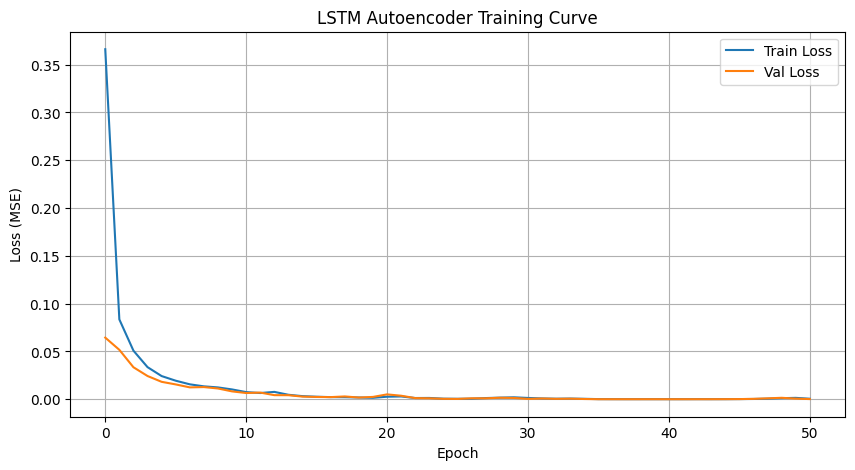

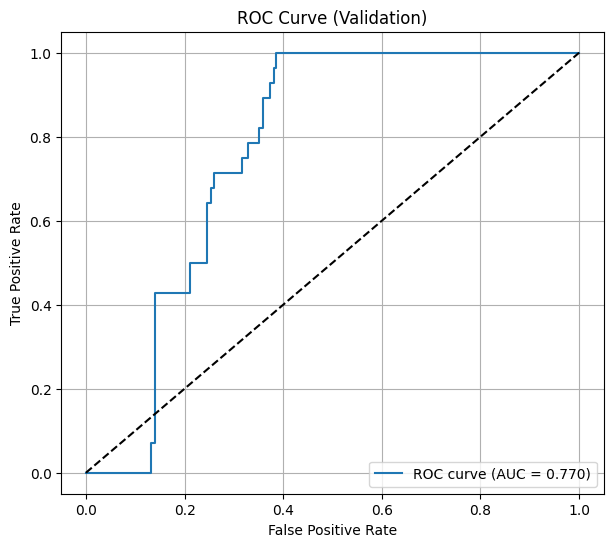

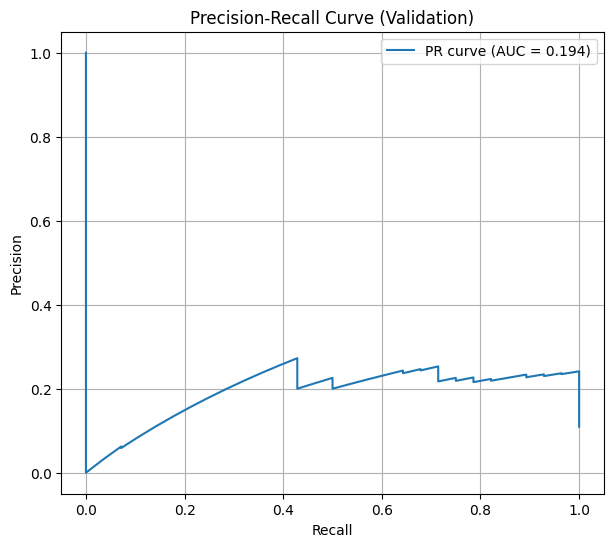

Matthews correlation coeff (MCC):
 0.3849874881099513


In [10]:

# 128-64-32
# F1 0.35
# matt 0.28
#auc 0.700

# 256-128-32
# F1 0.37
# matt 0.30
#auc 0.729

# 256-128-16
# F1 0.39
# matt 0.38
#auc 0.770

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Autoencoder Training Curve")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ROC
fpr, tpr, _ = roc_curve(y_val, mse_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.savefig('roc.pdf')
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, mse_val)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import matthews_corrcoef
print("Matthews correlation coeff (MCC):\n", matthews_corrcoef(y_val, y_val_pred))